## Generative Adversarial Networks - Generating Handwitten Digits

Example by Josh Anthony: [https://github.com/joshanthony](https://github.com/joshanthony) 

Read the full blog post here: [https://joshanthony.github.io/generative-adversarial-networks/](https://joshanthony.github.io/generative-adversarial-networks)

***

In [51]:
# The following lines are used to increase the width of cells to utilize more space on the screen 
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

***

### Section 0: Imports

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Import the handwritten digits dataset
from keras.datasets.mnist import load_data 

# Import the Keras functionality we need
from tensorflow.keras.optimizers import Adam
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model

***

### Section 1: Explore the Dataset

In [53]:
# Collect the train and test data
(X_train, _), (_, _) = load_data()

In [54]:
# Visualise the size/shape of the dataset
print(f"Data shape {X_train.shape}")

Data shape (60000, 28, 28)


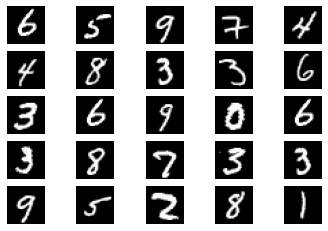

In [55]:
# Plot a random sample of 25 numbers from the training dataset to visualise the data
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.axis(False)
    plt.imshow(X_train[random.randint(0,99)], cmap='gray')

plt.show()

***

### Section 2: Define the Discriminator Model

In [56]:
# The discriminator model is binary classifier used to decide if a given input is real or fake
def discriminator_model(image_shape):
    # This model is a simple 3 dense layer neural network
    model = Sequential()

    model.add(Flatten(input_shape=image_shape))
    model.add(Dense(512, activation=LeakyReLU(alpha=0.2)))
    model.add(Dense(256, activation=LeakyReLU(alpha=0.2)))
    model.add(Dense(1, activation='sigmoid')) # sigmoid provides output 0 - 1 which is ideal for binary classification
    
    model.summary()

    model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
    
    return model

***

### Section 3: Define the Generator Model

In [57]:
# The generator model takes in noise from the latent space and generates fake samples of data
def generator_model(latent_space, image_shape):
    model = Sequential()

    model.add(Dense(256, input_dim=latent_space, activation=LeakyReLU(alpha=0.2)))
    model.add(Dense(512, activation=LeakyReLU(alpha=0.2)))
    model.add(Dense(1024, activation=LeakyReLU(alpha=0.2)))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(image_shape), activation='tanh')) # tanh provides output -1 - 1 which is ideal for an image
    model.add(Reshape(image_shape))

    model.summary()

    return model

***

### Section 4: Join and Initialise the GAN Models

In [58]:
def GAN_models(latent_space):
    image_size = 28 # 28 x 28 final image
    num_channels = 1 # The network expects a 3D image with a dimension for width, height and greyscale
    image_shape = (image_size, image_size, num_channels)
    
    # Initialise generator model
    generator = generator_model(latent_space, image_shape)
    
    # Initialise discriminator model
    discriminator = discriminator_model(image_shape)

    # Freeze the weights of the discriminator for now, we can unlock these when we need to train it
    discriminator.trainable = False
    
    # The generator's input is noise from the latent space
    inputs = Input(shape=(latent_space,))
    image = generator(inputs)

    # The discriminator's input is image data from the generator
    output = discriminator(image)

    # Combine generator and discriminator models to make the full GAN
    gan = Model(inputs, output)
    gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

    return generator, discriminator, gan

In [59]:
latent_space = 128 # Random values / noise vector size

# Initialise our models
generator, discriminator, gan = GAN_models(latent_space)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_29 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_30 (Dense)             (None, 1024)              525312    
_________________________________________________________________
batch_normalization_4 (Batch (None, 1024)              4096      
_________________________________________________________________
dense_31 (Dense)             (None, 784)               803600    
_________________________________________________________________
reshape_4 (Reshape)          (None, 28, 28, 1)         0         
Total params: 1,497,616
Trainable params: 1,495,568
Non-trainable params: 2,048
________________________________________

***

### Section 5: Train the GAN and plot the results

In [60]:
def train_model(generator, discriminator, gan, X_train, latent_space, epochs):
    
    batch_size = 128 # Train in batches of 128
    sample_interval = 100
    print_interval = 25
    discriminator_loss = []
    generator_loss = []
    
    # Scale training data as we need (width, height, greyscale) properties on each image
    X_train = X_train / 127.5 - 1.
    X_train = np.expand_dims(X_train, axis=3)

    for epoch in range(epochs):

        # Step 1: training the discriminator model
        
        # Get a random set of real images
        image_batch = X_train[np.random.randint(0, X_train.shape[0], batch_size)]

        # Generate a set of noise from the latent space
        noise = np.random.normal(0, 1, (batch_size, latent_space))

        # Generate new set of fake digits
        generated_images = generator.predict(noise)
        
        # Combine our real and fake data into a training dataset
        X = np.concatenate((image_batch, generated_images))
        y = np.zeros(batch_size * 2) # labels
        y[:batch_size] = 1

        # Unfreeze the weights and train the discriminator on the combined training dataset
        discriminator.trainable = True
        d_loss = discriminator.train_on_batch(X, y)
        
        # Freeze the weights of the discriminator again so we can train the generator
        discriminator.trainable = False

        # Step 2: training the generator model

        # Generate noise from the latent space
        noise = np.random.normal(0, 1, (batch_size, latent_space))

        # Run the GAN with discriminator set as not-trainable in order to train only the generator
        y2 = np.ones(batch_size) # labels
        g_loss = gan.train_on_batch(noise, y2)

        # Periodically plot the training progress
        if epoch % print_interval == 0:
            print(f"{epoch} => discriminator loss: {d_loss[0]}, generator loss: {g_loss}")
            discriminator_loss.append(d_loss[0])
            generator_loss.append(g_loss)

        # Periodically plot the generated images
        if epoch % sample_interval == 0:
            plot_generated(generated_images, epoch)
    
    # Plot the loss of the discriminator and generator at the end        
    plot_loss(discriminator_loss, generator_loss)
            
    
def plot_generated(generated_images, epoch):
    # 5 x 5 grid
    rows, columns = 5, 5
    # Scale the generated images
    generated_images = 0.5 * generated_images + 0.5

    # Plot the images onto a 5 x 5 grid
    fig, axs = plt.subplots(rows, columns)
    count = 0
    for i in range(rows):
        for j in range(columns):
            axs[i,j].imshow(generated_images[count, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            count += 1
    # Save the images into a /results/ folder
    fig.savefig("results/%d.png" % epoch)
    plt.close()
    
# Plot the discriminator and generator loss
def plot_loss(discriminator_loss, generator_loss):
    plt.figure()
    
    plt.plot(discriminator_loss, label="Discriminator loss")
    plt.plot(generator_loss, label="Generator loss")
    
    plt.ylabel('Loss Values')
    plt.xlabel('Epochs')
    
    plt.legend()
    plt.show()

0 => discriminator loss: 0.6351349949836731, generator loss: 0.6335228681564331
25 => discriminator loss: 0.06634751707315445, generator loss: 2.4399361610412598
50 => discriminator loss: 0.02314620278775692, generator loss: 3.1340763568878174
75 => discriminator loss: 0.02201146073639393, generator loss: 3.5640926361083984
100 => discriminator loss: 0.022886311635375023, generator loss: 3.3851006031036377
125 => discriminator loss: 0.025321483612060547, generator loss: 3.258118152618408
150 => discriminator loss: 0.05579177290201187, generator loss: 3.55433988571167
175 => discriminator loss: 0.2836710512638092, generator loss: 1.7707960605621338
200 => discriminator loss: 0.36477911472320557, generator loss: 0.7753070592880249
225 => discriminator loss: 0.4722664952278137, generator loss: 0.9417270421981812
250 => discriminator loss: 0.34083646535873413, generator loss: 0.7327999472618103
275 => discriminator loss: 0.4918804168701172, generator loss: 0.8908238410949707
300 => discrim

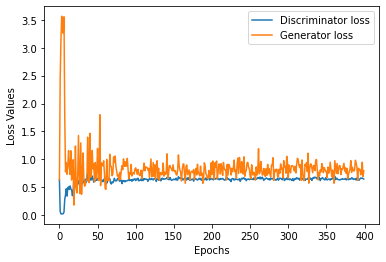

In [61]:
epochs = 10000
train_model(generator, discriminator, gan, X_train, latent_space, epochs)